# Project: Road Accidents in France based on Annual Road Traffic Accident Injury Database (2005 - 2023)

## Step 2: Baseline Models - 2-Class 

Import required libraries and load the cleaned dataset containing accident records

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Standard libraries
import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & feature engineering
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import TruncatedSVD

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Imbalanced data handling
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from collections import Counter
from sklearn.utils.class_weight import compute_sample_weight

In [3]:
file_path = "../data/processed/df_for_ml.csv"
df = pd.read_csv(file_path, low_memory=False)

In [4]:
# Convert to 'category' dtype
category_columns = [
    'lum', 'int', 'atm', 'col', 'circ', 'vosp', 'prof', 'plan', 'surf',
    'infra', 'situ', 'senc', 'obs', 'obsm', 'choc', 'catu', 'grav', 'sexe',
    'dayofweek', 'belt_status', 'agg_catr', 'catv_group', 'rush_hour',
    'season', 'age_bin', 'belt_user_type_code'
]

for col in category_columns:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Convert to nullable integers (Int64)
nullable_int_columns = ['nbv', 'age']
for col in nullable_int_columns:
    if col in df.columns:
        df[col] = df[col].astype('Int64')

# Leave 'hour' as standard integer
if 'hour' in df.columns:
    df['hour'] = df['hour'].astype('int64')

print(df.dtypes)

lum                    category
int                    category
atm                    category
col                    category
circ                   category
nbv                       Int64
vosp                   category
prof                   category
plan                   category
surf                   category
infra                  category
situ                   category
senc                   category
obs                    category
obsm                   category
choc                   category
catu                   category
grav                   category
sexe                   category
hour                      int64
dayofweek              category
belt_status            category
age                       Int64
agg_catr               category
catv_group             category
rush_hour              category
season                 category
age_bin                category
belt_user_type_code    category
dtype: object


# Models and Evaluation

## Model Evaluation

Each model is trained and evaluated using:

- **Stratified 80/20 train-test split**
- **Pipeline-based preprocessing**
- **Metrics**:
  - Accuracy
  - Precision
  - Recall
  - F1-score (`classification_report`)
- **Cross-validation** (`GridSearchCV`) for logistic regression and decision tree, using macro-averaged F1 score to handle class imbalance.

This setup ensures a fair comparison and robust performance assessment while avoiding data leakage and overfitting.

In [6]:
# ----- PARAMETERS -----
use_full_data = False  # Set to True to use the full dataset
sample_fraction = 0.2  # 20% of the data

In [10]:
# ----- LABEL PROCESSING -----

# 2-class mapping
grav_mapping = {
    1: "Minor/None",
    2: "Hospitalized/Killed",
    3: "Hospitalized/Killed",
    4: "Minor/None"
}
df["grav_label"] = df["grav"].map(grav_mapping)

# Optional sampling
if not use_full_data:
    df = df.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)

# Encode target
label_encoder = LabelEncoder()
y = pd.Series(label_encoder.fit_transform(df["grav_label"]))
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Drop label columns from input
X = df.drop(columns=["grav", "grav_label"])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Detect feature types
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64', 'Int64']).columns.tolist()

# Distribution check
print("Class distribution:\n", y.value_counts(normalize=True).sort_index())
print("Class mapping:", class_mapping)

Class distribution:
 0    0.156252
1    0.843748
Name: proportion, dtype: float64
Class mapping: {'Hospitalized/Killed': 0, 'Minor/None': 1}


In [12]:
# Preprocessor pipeline
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), numeric_features),
    
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=True)),
        ("varthresh", VarianceThreshold(threshold=0.05))
    ]), categorical_features)
])

## RF_undersampled_2_classes
**Description:**  
Random Forest trained on an undersampled dataset where the majority class (non-severe accidents) is reduced to match the minority class.  

**Trade-offs:**  
- ✅ Improves balance and minority recall.  
- ❌ Risk of losing valuable information from discarded majority samples → lower overall accuracy. 


🔍 Tuning model: Random Forest 2class_undersampled
Fitting 3 folds for each of 6 candidates, totalling 18 fits

✅ Best parameters for Random Forest 2class_undersampled: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
                     precision    recall  f1-score   support

Hospitalized/Killed       0.36      0.82      0.50     34461
         Minor/None       0.96      0.74      0.83    186088

           accuracy                           0.75    220549
          macro avg       0.66      0.78      0.67    220549
       weighted avg       0.86      0.75      0.78    220549



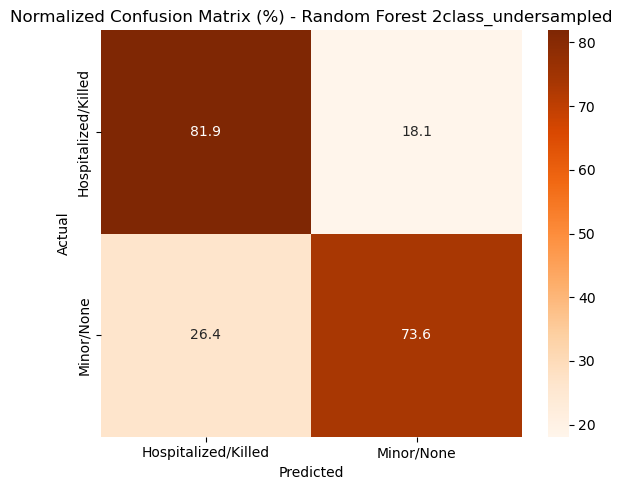

In [14]:
from imblearn.pipeline import Pipeline

# Define model
model_name = "Random Forest 2class_undersampled"
model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# Hyperparameter grid
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

# Evaluation setup
severity_labels = ["Hospitalized/Killed", "Minor/None"]
results = {}

# Build pipeline with undersampling
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("undersampler", RandomUnderSampler(random_state=42)),
    ("classifier", model)
])

# Grid search
print(f"\n🔍 Tuning model: {model_name}")
search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=1,
    verbose=1
)

search.fit(X_train, y_train)
y_pred = search.predict(X_test)

# Evaluation
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

results[model_name] = {
    "model_name": model_name,
    "best_params": search.best_params_,
    "classification_report": report_dict,
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_percent": cm_percent.tolist()
}

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y_test, y_pred, target_names=severity_labels, zero_division=0))

safe_name = model_name.replace(" ", "_").replace("(", "").replace(")", "")

# 🟠 Normalized confusion matrix heatmap
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()

## RF_cost_sensitive_2_classes
**Description:**  
Random Forest trained with **misclassification costs** built into the splitting and voting process, penalizing errors on severe cases more heavily.  

**Trade-offs:**  
- ✅ Directly addresses the imbalance without resampling.  
- ✅ Retains full dataset.  
- ❌ Harder to calibrate misclassification costs.  
- ❌ May bias too heavily toward the minority if costs are extreme.  


🔍 Tuning model: Random Forest 2class_cost_sensitive
Fitting 3 folds for each of 6 candidates, totalling 18 fits

✅ Best parameters for Random Forest 2class_cost_sensitive: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
                     precision    recall  f1-score   support

Hospitalized/Killed       0.61      0.51      0.55     34461
         Minor/None       0.91      0.94      0.93    186088

           accuracy                           0.87    220549
          macro avg       0.76      0.72      0.74    220549
       weighted avg       0.86      0.87      0.87    220549



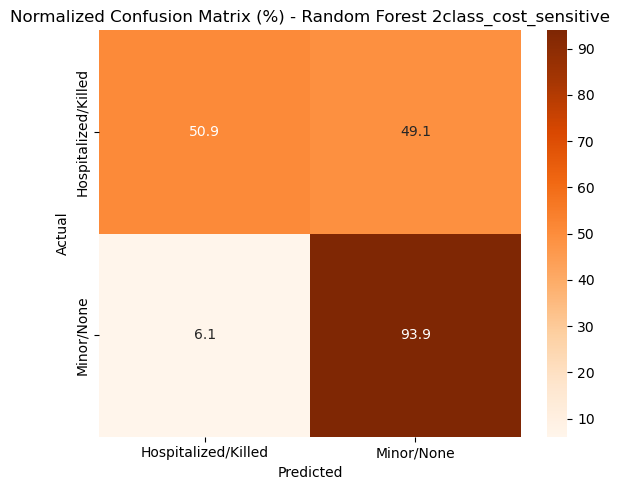

In [16]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline 

# New model name
model_name = "Random Forest 2class_cost_sensitive"

# Cost-sensitive model
model = RandomForestClassifier(
    random_state=42,
    class_weight={0:30, 1:1},
    n_jobs=-1
)

# Hyperparameter grid
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

# Evaluation setup
severity_labels = ["Hospitalized/Killed", "Minor/None"]
results = {}

# Pipeline 
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", model)
])

# Grid search
print(f"\n🔍 Tuning model: {model_name}")
search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=1,
    verbose=1
)

search.fit(X_train, y_train)
y_pred = search.predict(X_test)

# Evaluation
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

results[model_name] = {
    "model_name": model_name,
    "best_params": search.best_params_,
    "classification_report": report_dict,
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_percent": cm_percent.tolist()
}

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y_test, y_pred, target_names=severity_labels, zero_division=0))

# 🟠 Normalized confusion matrix heatmap
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()


## BalancedBagging_RF_2_classes
**Description:**  
Bagging ensemble of Random Forests, each trained on **balanced bootstrap samples** (equal severe and non-severe cases).  

**Trade-offs:**  
- ✅ Retains more diversity than plain undersampling.  
- ✅ Often improves recall without drastically reducing accuracy.  
- ❌ Higher computational cost due to multiple Random Forests.  


🔍 Tuning model: BalancedBagging_RF_2class
Fitting 3 folds for each of 4 candidates, totalling 12 fits

✅ Best parameters for BalancedBagging_RF_2class: {'classifier__estimator__max_depth': 20, 'classifier__estimator__min_samples_split': 2, 'classifier__estimator__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.36      0.78      0.49     34461
           1       0.95      0.74      0.83    186088

    accuracy                           0.75    220549
   macro avg       0.65      0.76      0.66    220549
weighted avg       0.86      0.75      0.78    220549



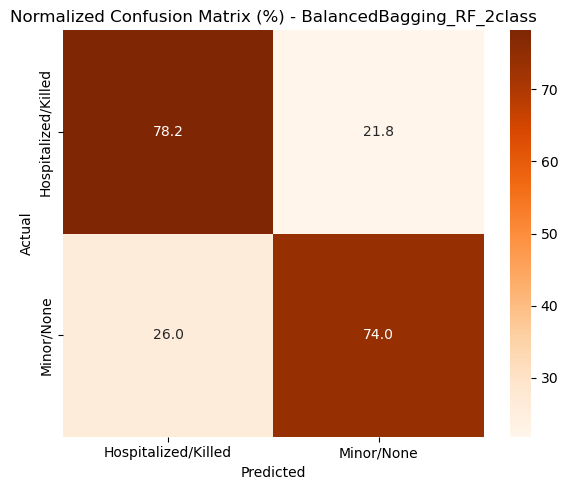

In [17]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline

model_name = "BalancedBagging_RF_2class"
base_estimator = RandomForestClassifier(n_jobs=-1, random_state=42)

bbc = BalancedBaggingClassifier(
    estimator=base_estimator,
    sampling_strategy="auto",
    replacement=False,
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "classifier__estimator__n_estimators": [100],
    "classifier__estimator__max_depth": [10, 20],
    "classifier__estimator__min_samples_split": [2, 5]
}

severity_labels = ["Hospitalized/Killed", "Minor/None"]
results = {}

# Pipeline + Grid Search
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", bbc)
])

print(f"\n🔍 Tuning model: {model_name}")
search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=1,
    verbose=1
)

search.fit(X_train, y_train)
y_pred = search.predict(X_test)

# Evaluation
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

results[model_name] = {
    "model_name": model_name,
    "best_params": search.best_params_,
    "classification_report": report_dict,
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_percent": cm_percent.tolist()
}

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y_test, y_pred, zero_division=0))

# 🟠 Normalized Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()

## BalancedRandomForest_2_classes
**Description:**  
Random Forest variant where **each tree is built on a balanced bootstrap sample**, ensuring equal class representation at training.  

**Trade-offs:**  
- ✅ Strong recall on severe cases.  
- ✅ More stable than simple undersampling.  
- ❌ May reduce precision and overall accuracy.  
- ❌ Still more expensive to train than standard RF.  


🔍 Tuning model: BalancedRandomForest_2class
Fitting 3 folds for each of 6 candidates, totalling 18 fits

✅ Best parameters for BalancedRandomForest_2class: {'classifier__max_depth': None, 'classifier__min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.45      0.73      0.56     34461
           1       0.94      0.84      0.89    186088

    accuracy                           0.82    220549
   macro avg       0.70      0.78      0.72    220549
weighted avg       0.87      0.82      0.83    220549



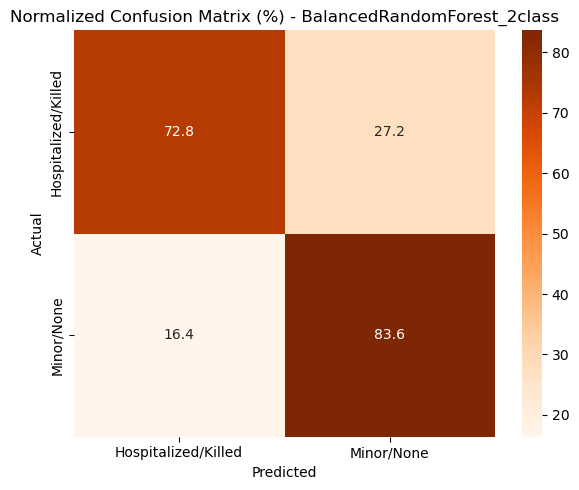

In [18]:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import os

model_name = "BalancedRandomForest_2class"

# Define model
brf = BalancedRandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# Hyperparameter grid
param_grid = {
    "classifier__max_depth": [10, 20, None],
    "classifier__min_samples_split": [2, 5]
}

severity_labels = ["Hospitalized/Killed", "Minor/None"]
results = {}

# Pipeline with preprocessing
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", brf)
])

# Grid search
print(f"\n🔍 Tuning model: {model_name}")
search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=1,
    verbose=1
)

search.fit(X_train, y_train)
y_pred = search.predict(X_test)

# Evaluation
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

results[model_name] = {
    "model_name": model_name,
    "best_params": search.best_params_,
    "classification_report": report_dict,
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_percent": cm_percent.tolist()
}

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y_test, y_pred, zero_division=0))

# 🟠 Normalized Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()

## CatBoost_Balanced_2_classes
**Description:**  
CatBoost gradient boosting model with **class weights** to handle imbalance. Efficient with categorical features and resistant to overfitting.  

**Trade-offs:**  
- ✅ Strong predictive power, especially with categorical data.  
- ✅ Handles imbalance natively with class weights.  
- ❌ Slower training compared to trees/forests.  
- ❌ Requires careful tuning of weights.  


🔍 Tuning model: CatBoost_2class_Balanced
Fitting 3 folds for each of 2 candidates, totalling 6 fits

✅ Best parameters for CatBoost_2class_Balanced: {'classifier__depth': 10, 'classifier__iterations': 100, 'classifier__learning_rate': 0.1}
              precision    recall  f1-score   support

           0       0.33      0.78      0.46     34461
           1       0.95      0.71      0.81    186088

    accuracy                           0.72    220549
   macro avg       0.64      0.74      0.63    220549
weighted avg       0.85      0.72      0.75    220549



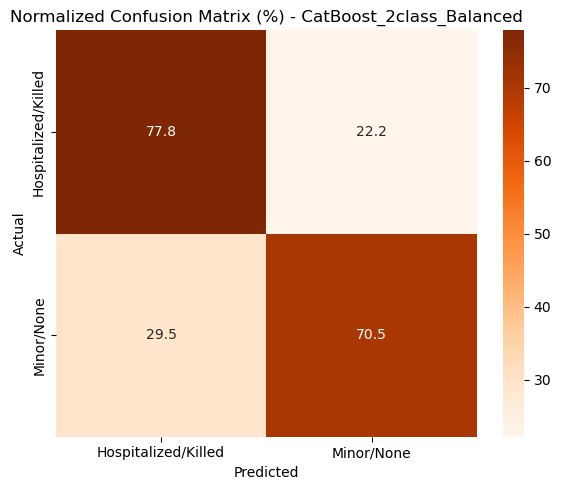

In [19]:
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

#Setup
model_name = "CatBoost_2class_Balanced"
severity_labels = ["Hospitalized/Killed", "Minor/None"]

#Estimate class weights using sklearn's compute_class_weight
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

#CatBoost Model
cat = CatBoostClassifier(
    loss_function='MultiClass',
    class_weights=class_weights,
    verbose=0,
    random_state=42
)

# GridSearch space
param_grid = {
    'classifier__iterations': [100],
    'classifier__depth': [6, 10],
    'classifier__learning_rate': [0.1]
}

# Pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", cat)
])

# Grid Search
search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

print(f"\n🔍 Tuning model: {model_name}")
search.fit(X_train, y_train)
y_pred = search.predict(X_test)

# Evaluation
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y_test, y_pred, zero_division=0))

# 🟠 Normalized Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()

## XGBoost_weighted_2_classes
**Description:**  
XGBoost classifier where **severe cases are penalized more heavily** via class-weighted loss. Focuses on improving minority-class detection.  

**Trade-offs:**  
- ✅ Excellent performance with tabular data.  
- ✅ Flexible weighting for imbalance.  
- ❌ Computationally heavy.  
- ❌ Sensitive to hyperparameters and prone to overfitting if not tuned well.  

Class weights: {0: 3.1999651780273353, 1: 0.5925937867771526}

🔍 Tuning model: XGBoost_2class_weighted
Fitting 3 folds for each of 8 candidates, totalling 24 fits

✅ Best parameters for XGBoost_2class_weighted: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 8, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 300, 'classifier__subsample': 0.8}
              precision    recall  f1-score   support

           0       0.35      0.77      0.48     34461
           1       0.95      0.74      0.83    186088

    accuracy                           0.74    220549
   macro avg       0.65      0.75      0.66    220549
weighted avg       0.85      0.74      0.78    220549



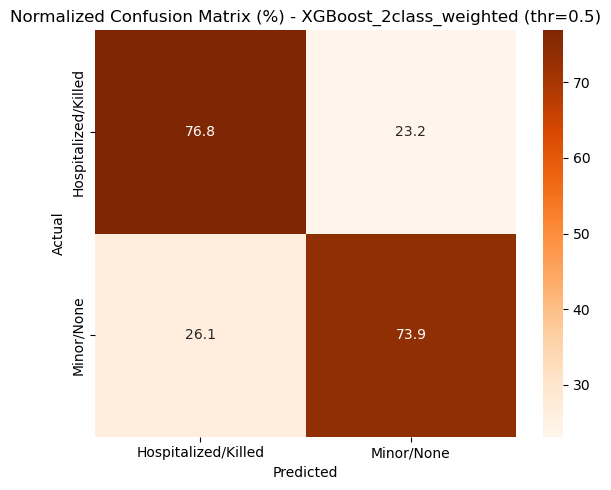


📈 AUC-PR (severe positive): 0.499
🏁 F1-optimal severe threshold: 0.6075 | P=0.420, R=0.631

=== Classification Report @ severe F1-opt threshold ===
              precision    recall  f1-score   support

           0       0.42      0.63      0.50     34461
           1       0.92      0.84      0.88    186088

    accuracy                           0.81    220549
   macro avg       0.67      0.73      0.69    220549
weighted avg       0.85      0.81      0.82    220549



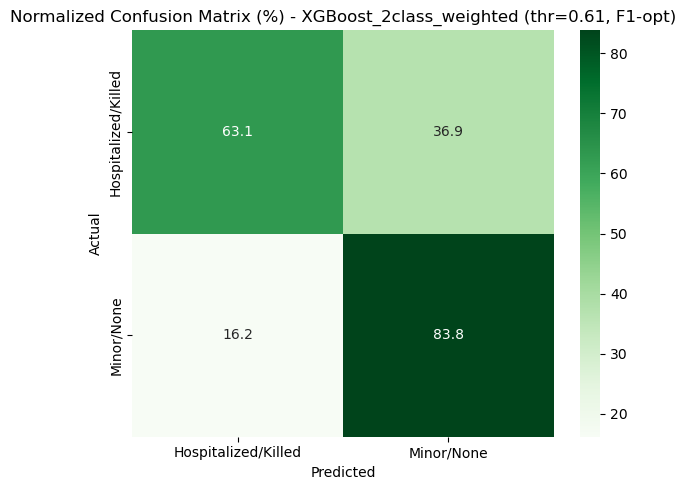

In [20]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.utils.class_weight import compute_class_weight

# Setup
model_name = "XGBoost_2class_weighted"
severity_labels = ["Hospitalized/Killed", "Minor/None"]  # assumes y: 0=severe, 1=non-severe

# Class weights -> sample weights (so we can weight class 0 = severe more)
classes = np.unique(y_train)              # expected [0, 1]
weights = compute_class_weight("balanced", classes=classes, y=y_train)
class_weights = dict(zip([int(c) for c in classes], [float(w) for w in weights]))
print("Class weights:", class_weights)

sample_weight_train = np.array([class_weights[int(y)] for y in y_train], dtype="float32")

# XGBoost (binary)
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

# Pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", xgb)
])

# GridSearch space
param_grid = {
    "classifier__n_estimators": [300],
    "classifier__max_depth": [4, 8],
    "classifier__learning_rate": [0.05, 0.1],
    "classifier__subsample": [0.8],
    "classifier__colsample_bytree": [0.8],
    "classifier__min_child_weight": [1, 5],
}

# 🔍 Grid Search
print(f"\n🔍 Tuning model: {model_name}")
search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Pass per-sample weights (GridSearch will slice them per fold)
search.fit(X_train, y_train, **{"classifier__sample_weight": sample_weight_train})

# Evaluation @ default threshold (0.5)
y_pred = search.predict(X_test)

report_dict_thr05 = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
cm_thr05 = confusion_matrix(y_test, y_pred)
cm_thr05_pct = cm_thr05.astype(float) / cm_thr05.sum(axis=1, keepdims=True) * 100

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y_test, y_pred, zero_division=0))

# 🟠 Normalized Confusion Matrix (%)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_thr05_pct, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name} (thr=0.5)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()

# Threshold tuning for Severe (class 0) 

best_est = search.best_estimator_
proba = best_est.predict_proba(X_test)  # columns correspond to classes_ order
classes_order = best_est.named_steps["classifier"].classes_
severe_idx = int(np.where(classes_order == 0)[0][0])  # index of class 0 in proba output

p_severe = proba[:, severe_idx]  # P(y=0)
y_true_severe_pos = (y_test == 0).astype(int)

prec, rec, thr = precision_recall_curve(y_true_severe_pos, p_severe)
f1 = (2 * prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1)
thr_f1 = thr[best_idx] if best_idx < len(thr) else 0.5
auc_pr = auc(rec, prec)

print(f"\n📈 AUC-PR (severe positive): {auc_pr:.3f}")
print(f"🏁 F1-optimal severe threshold: {thr_f1:.4f} | P={prec[best_idx]:.3f}, R={rec[best_idx]:.3f}")

# Apply tuned threshold
y_pred_severe = (p_severe >= thr_f1).astype(int)      # 1=severe (local)
y_pred_thrF1 = np.where(y_pred_severe == 1, 0, 1)     # map back to labels {0,1}

print("\n=== Classification Report @ severe F1-opt threshold ===")
report_dict_thrF1 = classification_report(y_test, y_pred_thrF1, output_dict=True, zero_division=0)
print(classification_report(y_test, y_pred_thrF1, zero_division=0))

cm_thrF1 = confusion_matrix(y_test, y_pred_thrF1)
cm_thrF1_pct = cm_thrF1.astype(float) / cm_thrF1.sum(axis=1, keepdims=True) * 100


fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_thrF1_pct, annot=True, fmt=".1f", cmap="Greens",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name} (thr={thr_f1:.2f}, F1-opt)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()

## BalancedBagging_2_classes
**Description:**  
Balanced bagging ensemble of **decision trees** (not full Random Forests). Each tree is trained on balanced resampled data.  

**Trade-offs:**  
- ✅ Simple and effective for imbalance.  
- ✅ Less prone to overfitting than a single tree.  
- ❌ Weaker than Random Forest/Boosting in raw predictive power.  


🔍 Training model: BalancedBagging 2class

✅ Evaluation for BalancedBagging 2class
                     precision    recall  f1-score   support

Hospitalized/Killed       0.31      0.77      0.45    172305
         Minor/None       0.94      0.69      0.79    930436

           accuracy                           0.70   1102741
          macro avg       0.63      0.73      0.62   1102741
       weighted avg       0.84      0.70      0.74   1102741



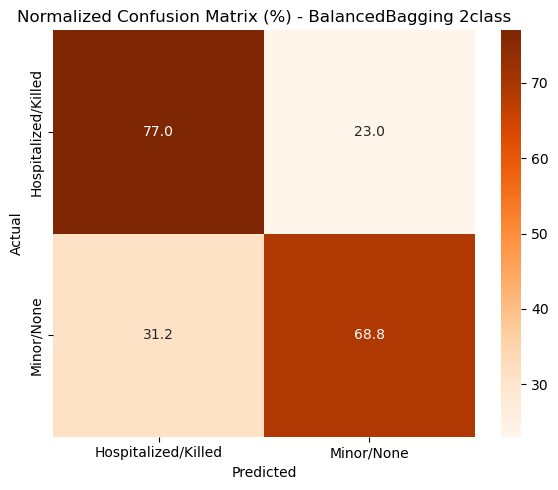

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.pipeline import Pipeline

# ----- CONFIGURATION -----
model_name = "BalancedBagging 2class"
safe_name = model_name.replace(" ", "_").replace("(", "").replace(")", "")
severity_labels = ["Hospitalized/Killed", "Minor/None"]
top_n = 20
results = {}

# ----- BASE ESTIMATOR -----
base_model = DecisionTreeClassifier(
    max_depth=10,
    class_weight='balanced',
    random_state=42
)

bbc = BalancedBaggingClassifier(
    estimator=base_model,
    sampling_strategy='auto',
    n_estimators=10,
    random_state=42,
    n_jobs=-1
)

# ----- PIPELINE -----
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", bbc)
])

# ----- CROSS-VALIDATED PREDICTION -----
print(f"\n🔍 Training model: {model_name}")
y_pred = cross_val_predict(pipeline, X, y, cv=5, n_jobs=1)

# ----- EVALUATION -----
report_dict = classification_report(y, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

results[model_name] = {
    "model_name": model_name,
    "classification_report": report_dict,
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_percent": cm_percent.tolist()
}

print(f"\n✅ Evaluation for {model_name}")
print(classification_report(y, y_pred, target_names=severity_labels, zero_division=0))

# ----- PLOT CONFUSION MATRICES -----
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()